<a href="https://colab.research.google.com/github/solobala/RMSL_9/blob/main/NLP8_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.



In [43]:
import json
import bz2
import re
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Формируем список отзывов
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:16, 1478.10it/s]


In [ ]:
# Посмотрим на пример отзыва:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [ ]:
# Преобразуем список в датасрейм
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
df['text'] = df['text'].astype(str).apply(lambda x: x.lower()) # преобразуем  внижний регистр

## Часть 1. Анализ текстов

### Посчитайте количество отзывов в разных городах

In [ ]:
from string import punctuation # Это лишние символы, которые нужно будет удалить из городов и банков
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
df['city'] = df['city'].astype(str).apply(lambda x: x.lower().replace('г. ', '').replace('г.', "").replace('г ', "").replace('город ', "").replace('п.', "").replace('пгт.', "").replace('пгт', "").replace('(', "").replace(')',""))

In [ ]:
# Получим кол-во записей по топ 100 городов с наибольшим количеством отзывов.
df['city'].value_counts()[:100].sum()

135817

In [ ]:
# более 98% всех отзывов - по топ100 городам. Остальное - это опечатки,  города с небольшим количеством отзывов и пр. - можно не рассматривать
print(f'{round(135817/138325*100,2)}%')

98.19%


In [ ]:
# Выведем список таких городов  в порядке убывания
df['city'].value_counts()[:100]

москва             56787
none               15174
санкт-петербург    14664
новосибирск         2383
екатеринбург        2378
                   ...  
чита                 132
электросталь         130
стерлитамак          118
якутск               117
благовещенск         117
Name: city, Length: 100, dtype: int64

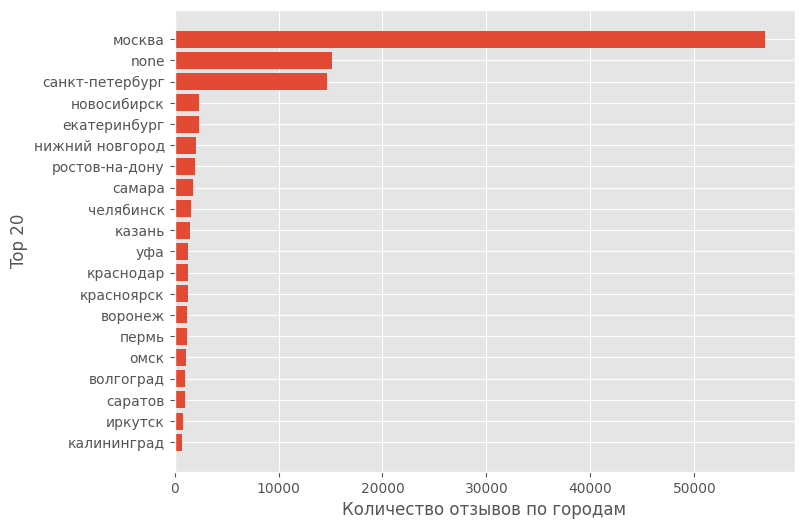

In [ ]:
cities = df.groupby(['city']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(cities.index[::-1],cities.values[::-1])
plt.xlabel('Количество отзывов по городам')
plt.ylabel('Top 20')
plt.show()

### Посчитайте количество отзывов на разные банки

In [ ]:
df['bank_name'].value_counts()

сбербанк россии     26327
альфа-банк          10224
втб 24               8185
русский стандарт     7943
хоум кредит банк     7549
                    ...  
донбанк                 1
потенциал               1
ури банк                1
чайна констракшн        1
вкабанк                 1
Name: bank_name, Length: 669, dtype: int64

In [ ]:
df['bank_name'] = df['bank_name'].astype(str).apply(lambda x: x.lower().replace('г. ', '').replace('г.', "").replace('г ', ""))

In [ ]:
df['bank_name'].value_counts()[:50].sum()

133324

In [ ]:
# Почти 87% приходится на топ50 банков. Остальные = опечатки и банки с небольшим количеством отзывов = можно не принимать во внимамние
print(f'{round(133324/153499*100,2)}%')

86.86%


In [ ]:
df['bank_name'].value_counts()[:50] # На рисунке - только 20 банков, иначе плохо видно

сбербанк россии                                         26327
альфа-банк                                              10224
втб 24                                                   8185
русский стандарт                                         7943
хоум кредит банк                                         7549
тинькофф банк                                            5387
национальный банк «траст»                                4607
ренессанс кредит                                         3849
связной банк                                             3775
отп банк                                                 3237
восточный экспресс банк                                  3138
райффайзенбанк                                           3057
московский кредитный банк                                2944
ситибанк                                                 2848
авангард                                                 2733
промсвязьбанк                                            2586
юникреди

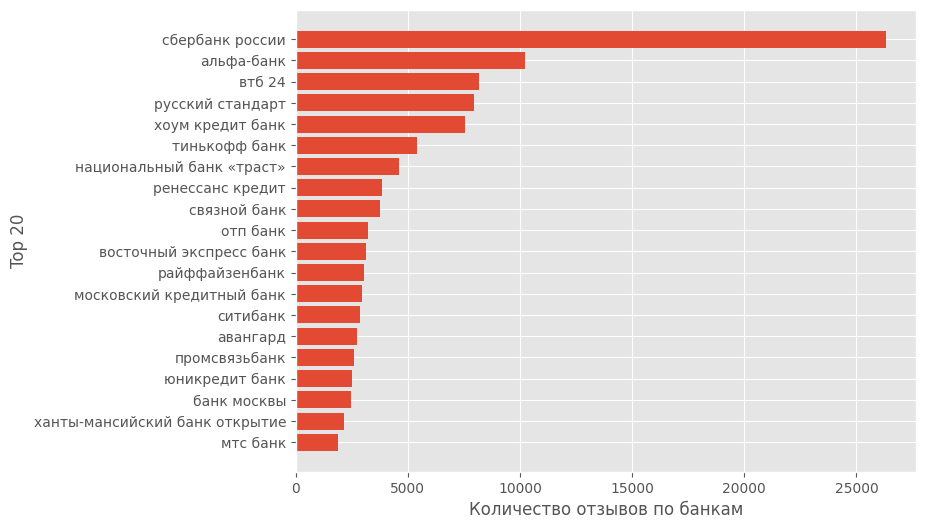

In [ ]:
banks = df.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(banks.index[::-1],banks.values[::-1])
plt.xlabel('Количество отзывов по банкам')
plt.ylabel('Top 20')
plt.show()

### Постройте гистограмы длин слов в символах и в словах

In [ ]:
from nltk.tokenize import word_tokenize





* Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм
    * существительных
* Постройте кривые Ципфа и Хипса
* Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
* В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts-ru

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from string import punctuation

In [ ]:
noise = stopwords.words('russian') + list(punctuation) + ['``', "''", '...', 'это', ' ', ', ', '  ', ' - ', ' "', ' )',' (']

In [ ]:
def remove_stopwords(text, mystopwords=noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [ ]:
df['text_tokenized'] =  df.text.str.lower().apply(words_only)
df['text_tokenized_stop_worlds'] = df.text_tokenized.str.lower().apply(remove_stopwords)

In [ ]:
import multiprocessing as mp
import pymorphy2

# создание объекта лемматизатора
morph = pymorphy2.MorphAnalyzer()
# функция для лемматизации одного слова
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

# функция для лемматизации текста в отдельном потоке
def process_text(text):
    words = text.split()
    with mp.Pool() as pool:
        lemmas = pool.map(lemmatize_word, words)
    return ' '.join(lemmas)

def lemmatize(text):
    from pymystem3 import Mystem
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []

    for t in m.lemmatize(merged_text):
        if t != '|':
            doc.append(t)
        else:
            res.append(doc)
            doc = []

    return res

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed
batch_size = 1000
texts = df['text_tokenized_stop_worlds'].to_list()

text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]



# Вот здесь тоже немного магии :)
processed_texts_ = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

100%|██████████| 154/154 [19:13<00:00,  7.49s/it]


In [39]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_tokenized,text_tokenized_stop_worlds
0,москва,False,Жалоба,0,лицензия № 2562,uhnov1,бинбанк,2015-06-08 12:50:54,добрый день! я не являюсь клиентом банка и пор...,NaN,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...
1,новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,сбербанк россии,2015-06-08 11:09:57,доброго дня! являюсь держателем зарплатной кар...,NaN,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...
2,москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,бинбанк,2015-06-05 20:14:28,здравствуйте! дублирую свое заявление от 03.0...,NaN,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...
3,ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,сбербанк россии,2015-06-05 13:51:01,добрый день!! я открыл расчетный счет в сберба...,NaN,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...
4,челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,отп банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,г взяла кредит в вашем банке заявленная мною с...,г взяла кредит вашем банке заявленная мною сум...


In [ ]:
import pickle
with open('lemmas_.pkl', 'wb') as f:
            pickle.dump(processed_texts_, f)

In [41]:
res = []
for item in tqdm(processed_texts_):
  for el in item[0]:
    if el != ' ':
      res.append(el)

100%|██████████| 154/154 [00:00<00:00, 7629.70it/s]


In [ ]:
# Самые частотные слова
corpus = [token for response in df.text_tokenized for token in word_tokenize(response)]
freq_dict = Counter(corpus)
print('10 самых частых слов  в отзывах')
freq_dict.most_common(10)

In [ ]:
# самые частотные слова без учета стоп-слов
corpus = [token for response in df.text for token in word_tokenize(response) if token not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

In [ ]:
# самые частотные леммы без учета стоп-слов
batch_size = 1000 # выбираем размер батча
texts = df.text_tokenized_stop_worlds.to_list() # преобразуем столбец датафрейма в список
text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]

In [ ]:
# Выполняем лемматизацию отзывов из батча параллельно для сокращения времени
processed_texts = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))
# В результате параллельной обработки текстов отзывов требуется дольнейшая обработка processed_texts
result = []
for item in tqdm(processed_texts):
    item = [elem for elem in item[0] if elem not in noise]
    item = [elem for elem in item if elem != '']
    result += item
freq_dict = Counter(result)
print('10 самых частых лемм в отзывах без учета стоп-слов')
freq_dict.most_common(10)

## Часть 2. Тематическое моделирование
* Постройте несколько тематических моделей коллекции документов с разным числом тем.
* Приведите примеры понятных (интерпретируемых) тем.
* Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

## Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

* Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста:
  * использование только униграм,
  * использование пар или троек слов или
  * использованием символьных -грам.
* Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
  * 1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
  * 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.